In [154]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [155]:
def parse_filename(filename):
    fn_re = "pool-(?P<pool>.+)_expr-(?P<expr>.+)_sw-(?P<sw>\d+)"
    fn_re = fn_re + "_es-(?P<es>\d+)_qd-(?P<qd>\d+)_pg-(?P<pg>\d+)"
    fn_re = fn_re + "_rt-(?P<rt>\d+)_if-(?P<if>.+)\.log"
    fn_re = re.compile(fn_re)
    match = fn_re.match(os.path.basename(filename))
    assert match
    return match

In [184]:
def short_ename(ename):
    mapping = {
        'bytestream_n1_write': 'N:1, bytestream',
        'bytestream_n1_append': 'n1ap',
        'bytestream_11': '1:1, bytestream',
        'map_n1': 'N:1, KV',
        'map_11': '1:1, KV',
        
        'bytestream_n1_read': 'N:1, bytestream',
        'bytestream_11_read': '1:1, bytestream',
        'map_n1_read': 'N:1, KV',
        'map_11_read': '1:1, KV'
    }
    return mapping.get(ename, ename)

In [185]:
def read_trace(filename, trimFrontSec=30, trimBackSec=30):
    ### read up raw throughput file
    trace = pd.read_table(filename, sep=" ",
        header=None, names=("completed", "throughput"))
    
    ### shift timeseries to have zero start time
    trace.completed = pd.to_datetime(trace.completed, unit="ns")
    trace.completed = trace.completed - min(trace.completed)
    trace.completed = trace.completed / pd.Timedelta(seconds=1)
    
    ### trim front and back of trace
    trace = trace[(trace.completed > trimFrontSec) & (trace.completed <
        max(trace.completed) - trimBackSec)]
    trace.completed = trace.completed - min(trace.completed)
    
    ### order like a time series by the completion time of the I/O
    trace.sort_values(by='completed', ascending=True, inplace=True)
    return trace

In [186]:
def plot_throughput_trace(trace, filename, ax):
    trace.throughput = pd.rolling_mean(trace.throughput, window=5, min_periods=1)
    md = parse_filename(filename)
    label = md.group('expr')
    label = short_ename(label)
    #if 'es-128' in filename:
    #    label = label + " 128b"
    #elif 'es-1024' in filename:
    #    label = label + " 1KB"
    #elif 'es-4096' in filename:
    #    label = label + " 4KB"
    ax.plot(trace.completed, trace.throughput, label=label,)
    print label, trace.throughput.mean()
    #ax.set_title('Single OSD Throughput (Jewel 2016)')
    #ax.set_ylabel('Appends per Second per OSD')
    #ax.set_xlabel('Time (Sec)')

In [187]:
def plot_traces(traces, fn, finish=True, useAx=None):
    if useAx:
        ax = useAx
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    for filename in traces:
        trace_data = read_trace(filename)
        md = parse_filename(filename)
        #plot_throughput_trace(trace_data, md, ax)
        plot_throughput_trace(trace_data, filename, ax)
    if finish:
        lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(fn + '.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
    else:
        return ax

1:1, bytestream 22292.1411017
N:1, bytestream 29251.3193267
1:1, KV 4025.9104049
N:1, KV 13603.1446328


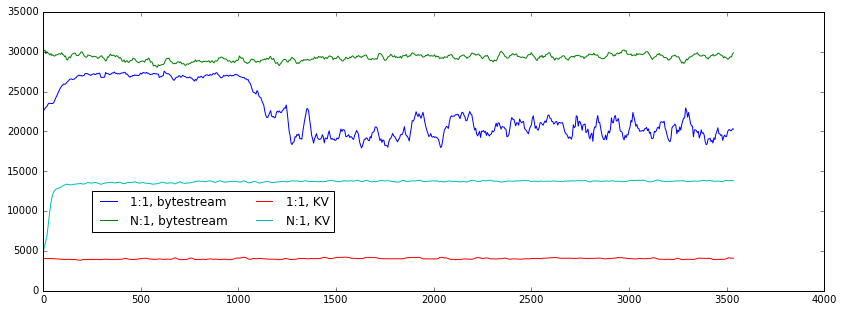

In [188]:
read_traces = glob.glob('results.pd.basic_cls_rand_read.node0.04-26-2016_20-43-54/*read*.log')
ax = plot_traces(list(read_traces), 'output.read.60min', finish=False)
lgd = ax.legend(loc='best', ncol=2, bbox_to_anchor=(0.42,0.42), bbox_transform=plt.gcf().transFigure)
plt.savefig('output.read.60min.1k.png', dpi=300, bbox_inches='tight')

1:1, bytestream 6384.31386535
N:1, bytestream 22176.1249294
1:1, KV 3691.88556968
N:1, KV 8944.00136535


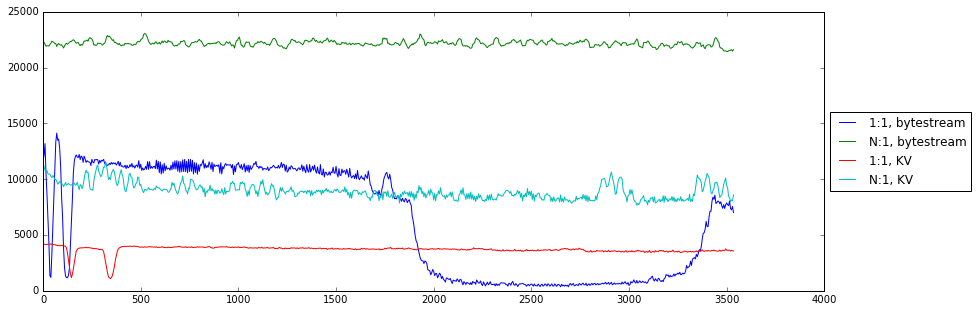

In [189]:
write_traces = [fn for fn in glob.glob('results.pd.basic_cls_rand_read.node0.04-26-2016_20-43-54/*.log')
                if not fn in read_traces]
plot_traces(list(write_traces), 'output.write.60min')

In [190]:
def plot_sub_sweep(ax, ver, iodir, conf, esize):
    dirfilter = '*librados_%s_%s_%s.node0*/*.log' % (ver, conf, esize)
    allfiles = sorted(glob.glob(dirfilter))
    readfiles = filter(lambda fn: '_read_' in fn, allfiles)
    if iodir == 'read':
        traces = readfiles
    else:
        traces = [fn for fn in allfiles if fn not in readfiles]
    plot_traces(list(traces), 'a', finish=False, useAx=ax)
    #lgd = ax.legend(loc='best', ncol=2)#, bbox_to_anchor=(0.42,0.42), bbox_transform=plt.gcf().transFigure)
    #plt.savefig('%s_reads.png' % name, dpi=300, bbox_inches='tight')
    
def plot_sweep(ver, iodir):
    plt.rcParams['figure.figsize'] = 15,4
    f1, axs1 = plt.subplots(1, 3, sharex=True, sharey=True)
    
    plot_sub_sweep(axs1[0], ver, iodir, 'ssd', 'small')
    plot_sub_sweep(axs1[1], ver, iodir, 'ssd', 'med')
    plot_sub_sweep(axs1[2], ver, iodir, 'ssd', 'large')
    axs1[0].set_ylabel('SSD')
    
    f2, axs2 = plt.subplots(1, 3, sharex=True, sharey=True)
    plot_sub_sweep(axs2[0], ver, iodir, 'hdd', 'small')
    plot_sub_sweep(axs2[1], ver, iodir, 'hdd', 'med')
    plot_sub_sweep(axs2[2], ver, iodir, 'hdd', 'large')
    axs2[0].set_ylabel('HDD')
    
    f3, axs3 = plt.subplots(1, 3, sharex=True, sharey=True)
    plot_sub_sweep(axs3[0], ver, iodir, 'ssd_hdd', 'small')
    plot_sub_sweep(axs3[1], ver, iodir, 'ssd_hdd', 'med')
    plot_sub_sweep(axs3[2], ver, iodir, 'ssd_hdd', 'large')
    axs3[0].set_ylabel('SSD+HDD')
    
    for axs in [axs1, axs2, axs3]:
        axs[0].set_title('512b Entry')
        axs[1].set_title('1K Entry')
        axs[2].set_title('4K Entry')
    
    #f.suptitle(ver + "_" + iodir, fontsize=14, y=1.01)
def cherry_pick(ax, iodir, dirfilter):
    allfiles = sorted(glob.glob(dirfilter))
    readfiles = filter(lambda fn: '_read_' in fn, allfiles)
    if iodir == 'read':
        traces = readfiles
    else:
        traces = [fn for fn in allfiles if fn not in readfiles]
    plot_traces(list(traces), 'a', finish=False, useAx=ax)
    #lgd = ax.legend(loc='best', ncol=2)#, bbox_to_anchor=(0.42,0.42), bbox_transform=plt.gcf().transFigure)
    #plt.savefig('%s_reads.png' % name, dpi=300, bbox_inches='tight')    

1:1, bytestream 10127.5736111
N:1, bytestream 17209.6930556
1:1, KV 3399.16925287
N:1, KV 3581.61029693
1:1, bytestream 6384.31386535
N:1, bytestream 22176.1249294
1:1, KV 3691.88556968
N:1, KV 8944.00136535
1:1, bytestream 10812.4234195
N:1, bytestream 23391.0314176
1:1, KV 3761.36403257
N:1, KV 18939.3763889
1:1, bytestream 1885.97859195
N:1, bytestream 1995.97413793
1:1, KV 1434.35871648
N:1, KV 1630.43347701
1:1, bytestream 1888.25598659
N:1, bytestream 2034.11853448
1:1, KV 1476.19032567
N:1, KV 1767.78922414
1:1, bytestream 1874.14655172
N:1, bytestream 2026.98611111
1:1, KV 1528.04683908
N:1, KV 1858.72485632


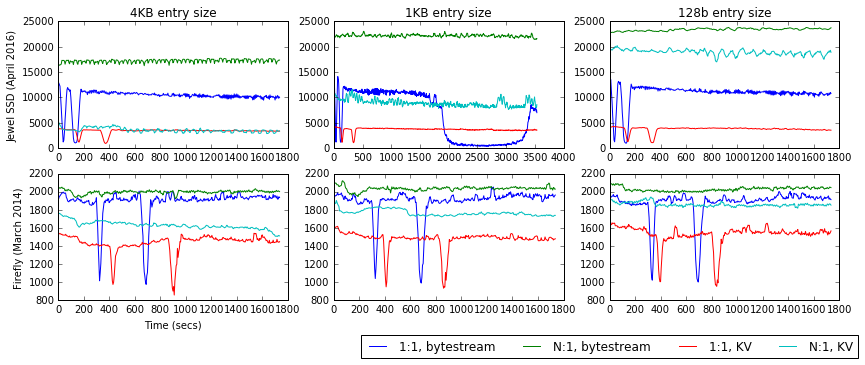

In [191]:
plt.rcParams['figure.figsize'] = 14,5

f, axs = plt.subplots(2,3)
plot_sub_sweep(axs[0,0], 'jewel', 'write', 'ssd', 'large')
cherry_pick(axs[0,1], 'write', 'results.pd.basic_cls_rand_read.node0.04-26-2016_20-43-54/*.log')
plot_sub_sweep(axs[0,2], 'jewel', 'write', 'ssd', 'small')
for i in range(0,2): axs[0, i].set_ylim(0, 25000)

plot_sub_sweep(axs[1,0], 'firefly', 'write', 'ssd', 'large')
plot_sub_sweep(axs[1,1], 'firefly', 'write', 'ssd', 'med')
plot_sub_sweep(axs[1,2], 'firefly', 'write', 'ssd', 'small')
#for i in range(0,2): axs[1, i].set_ylim(0, 22000)

axs[0,0].set_ylabel('Jewel SSD (April 2016)')
axs[1,0].set_ylabel('Firefly (March 2014)')
axs[1,0].set_xlabel('Time (secs)')

axs[0,0].set_title('4KB entry size')
axs[0,1].set_title('1KB entry size')
axs[0,2].set_title('128b entry size')

axs[1,2].legend(bbox_to_anchor=(0, -.5), loc='lower center', ncol=4)
plt.savefig('jewel_v_firefly_v_es.png', dpi=300, bbox_inches='tight')    

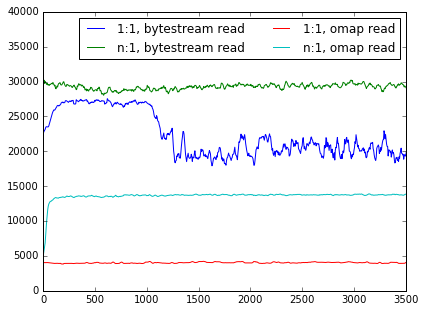

In [167]:
plt.rcParams['figure.figsize'] = 6.5,5
read_traces = glob.glob('results.pd.basic_cls_rand_read.node0.04-26-2016_20-43-54/*read*.log')
ax = plot_traces(list(read_traces), 'output.read.60min', finish=False)
ax.set_xlim(0, 3500)
ax.set_ylim(0, 40000)
lgd = ax.legend(loc='best', ncol=2)#, bbox_to_anchor=(0,0), bbox_transform=plt.gcf().transFigure)
plt.savefig('output.read.60min.1k.png', dpi=300, bbox_inches='tight')

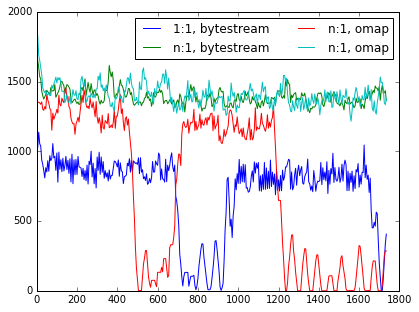

In [168]:
plt.rcParams['figure.figsize'] = 6.5,5
fig = plt.figure()
ax = fig.add_subplot(111)
plot_sub_sweep(ax, 'jewel', 'write', 'hdd', 'small')
lgd = ax.legend(loc='best', ncol=2)#, bbox_to_anchor=(0,0), bbox_transform=plt.gcf().transFigure)
plt.savefig('jewel-hdd-128b.png', dpi=300, bbox_inches='tight')